In [1]:
import pandas as pd
import numpy as np
import json
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# from sklearn import metrics

from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, recall_score,precision_recall_curve, f1_score, fbeta_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from collections import Counter

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from ipywidgets import widgets

In [2]:
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials
# def init_cred(cid):
#     '''client credentials flow. promtps for secret. returns sp object'''
#     secret = input("Give secret ID: ")
#     if secret:
#         os.environ['SPOTIPY_CLIENT_ID']= cid
#         os.environ['SPOTIPY_CLIENT_SECRET']= secret
#         client_credentials_manager = SpotifyClientCredentials()
#         return spotipy.Spotify(client_credentials_manager=client_credentials_manager)
#     else:
#         raise ValueError('Need a secret ID.')

In [3]:
# #INIT CREDENTIALS
# cid ="73dfaea6d85240e8bf6e69b48e12339e"
# sp = init_cred(cid)

In [4]:
#IMPORTING DFS
df_hist = pd.read_csv('df_hist.csv', header=0, sep=',', encoding='UTF-8')
df_lib = pd.read_csv('df_lib.csv', header=0, sep=',', encoding='UTF-8')
df_arch = pd.read_csv('df_arch.csv', header=0, sep=',', encoding='UTF-8')
df_meta = pd.read_csv('df_meta.csv', header=0, sep=',', encoding='UTF-8')
df_acoustic = pd.read_csv('df_acoustic.csv', header=0, sep=',', encoding='UTF-8')

In [5]:
#EDA on df_acoustic
'''['acousticness', #confidence 0-1
 'danceability', #confidence 0-1
 'duration_ms',
 'energy', #confidence 0-1
 'id',
 'instrumentalness', #confidence 0-1, but practically binary
 'key', #category
 'liveness', #confidence 0-1, but practically binary
 'loudness', #-60 to 0 #reg
 'mode', #category
 'speechiness', # 0-.33: no speech, 0.33-0.66: speech + music, 0.66+: talk show #reg
 'tempo', #confidence 0-1
 'time_signature', #category
 'valence' #confidence 0-1]'''
#merge key and mode -> key + 0.5*(mode-1)
df_acoustic.drop(columns=['mode'], inplace=True)
df_acoustic.drop(columns=[
                          # 'acousticness',
                          'danceability',
                          'duration_ms',
                          # 'energy',
                        #   'id',
                          # 'instrumentalness',
                          'key',
                          # 'liveness',
                          # 'loudness',
                          'speechiness',
                          'tempo',
                          'time_signature',
                          'valence'
                          ], inplace=True)
df_acoustic.astype({
                          'acousticness':np.float32,
                          # 'danceability':np.float32,
                          # 'duration_ms':np.float32,
                          'energy':np.float64,
                          'id':str,
                          'instrumentalness':np.float32,
                          # 'key':np.float32,
                          'liveness':np.float32,
                          'loudness':np.float32,
                          # 'speechiness':np.float32,
                          # 'tempo':np.float32,
                          # 'time_signature':np.float32,
                          # 'valence':np.float32
                          })
print('done')

done


In [6]:
#dim reduction
#L1
#Elastic Net
#saga solver
def reba(x, a, z):
    if a<=x and x<=z:
        x = x-a
        z = z-a
        return x/z
    elif z<x:
        return 1.0
    else:
        return np.nan

# df_acoustic['speechiness'] = df_acoustic['speechiness'].apply(lambda x: reba(x, 0.0, 0.666))

In [7]:
from sklearn import preprocessing
df_acoustic.reindex(axis= 0)
cols = ['id']
df_temp = df_acoustic.loc[:,cols].copy()
df_acoustic.drop(columns=cols, inplace=True)

x = df_acoustic.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_acoustic = pd.DataFrame(x_scaled, columns=df_acoustic.columns)
df_acoustic = df_acoustic.merge(df_temp, left_index=True, right_index=True)


In [8]:
#build sets
df_liked = pd.DataFrame()
df_liked['id'] = pd.concat([df_arch.id, df_lib.id], axis=0)
df_liked.drop_duplicates(subset=['id'],keep='first', inplace=True)
# print(df_liked.shape)
df_hist_unique = df_hist.drop_duplicates(subset=['id'], keep='first')
# print(df_hist_unique.shape)

df_sets = df_liked.merge(df_hist_unique, how='outer', on=['id'], indicator=True)

mask = df_sets['_merge'] == 'right_only'
df_neg = df_sets.loc[mask]
df_neg.drop(columns=['_merge', 'msPlayed'], inplace=True)
df_neg = df_neg.merge(df_acoustic, how = 'left', on=['id'], indicator=False)
df_neg['like'] = 0
print('df_neg ' + str(df_neg.shape))

mask = df_sets['_merge'] == 'both'
df_pos = df_sets.loc[mask]
df_pos.drop(columns=['_merge', 'msPlayed'], inplace=True)
df_pos = df_pos.merge(df_acoustic, how = 'left', on=['id'], indicator=False)
df_pos['like'] = 1
print('df_pos ' + str(df_pos.shape))

mask = df_sets['_merge'] == 'left_only'
df_innate = df_sets.loc[mask]
df_innate.drop(columns=['_merge', 'endTime', 'msPlayed'], inplace=True)
df_innate = df_innate.merge(df_acoustic, how = 'left', on=['id'], indicator=False)
df_innate['like'] = 1
df_innate['endTime'] = min(min(df_pos.endTime), min(df_pos.endTime))
print('df_innate ' + str(df_innate.shape))

df_dataset = df_pos.append(df_neg)
# #
df_dataset = df_dataset.append(df_innate)
# #
df_dataset.sort_values(by=['endTime'], axis=0, ascending=True, inplace=True, kind='mergesort', ignore_index=True)
print('df_dataset ' + str(df_dataset.shape))

df_dataset.drop(columns=['endTime'], inplace=True)
df_dataset.set_index(keys=['id'], drop=True, inplace=True)
a = df_dataset.shape[0]
df_dataset.dropna(axis=0, inplace=True)
print(a - df_dataset.shape[0])

#test, train, split
y_column = ['like']
X = df_dataset.drop(y_column, axis = 1)
y = df_dataset[y_column]
X_column = list(X.columns)
#global random seed
rand_global = 20
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = rand_global)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify = y_train_val, test_size = 0.33, random_state = rand_global)

# print((df_pos.shape[0] + df_innate.shape[0])/df_dataset.shape[0])

df_neg (4816, 8)
df_pos (1719, 8)
df_innate (578, 8)
df_dataset (7113, 8)
12


In [9]:
# X_train['like'] = y_train['like']
# X_train.to_csv('training.csv')

In [10]:
# df_train = X_train_val.copy()
# df_train['like'] = y_train_val
# df_train.loc[df_train.like == 1].var()
# # df_train.head()
# # sns.pairplot(df_train, hue='like').savefig('pairplot.png')

In [11]:
# sns.stripplot(x='instrumentalness',y='like', jitter=True,data=df_train,alpha=0.6);

In [12]:
# #plotly?

# import plotly.figure_factory as ff
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# df = X_train.loc[:,['acousticness', 'loudness', 'energy']].copy()
# df['like'] = y_train['like'].copy()

# data = []
# clusters = []
# colors = ['rgb(55,126,184)', 'rgb(255,127,14)'] # set our dot colors

# for i in range(len(df['like'].unique())): # allows us to split our data into three distinct groups
#     name = df['like'].unique()[i]
#     color = colors[i]
#     x = df[ df['like'] == name ]['acousticness']
#     y = df[ df['like'] == name ]['loudness']
#     z = df[ df['like'] == name ]['energy']
    
#     trace = dict(  # trace is how we "trace" or draw our data on the canvas
#         name = str(name),
#         x = x, y = y, z = z,
#         type = "scatter3d",
#         mode = 'markers',
#         marker = dict( size=3, color=color, line=dict(width=0) ) )
#     data.append( trace )

# layout = dict( # we modify our canvas here, including initial layout and styles
#     width=500,
#     height=800,
#     autosize=False,
#     title='Acousticness v Loudness v Energy',
#     scene=dict(
#         xaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)',
#             title='acousticness',  # set titles, very important
#             titlefont=dict(
#             family='Courier New',
#             size=14,
#             color='#2f2f2f'),  # we can use hex, rgba, or other color variants
#         ),
#         yaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)',
#             title='loudness',  # set titles, very important
#             titlefont=dict(
#             family='Courier New',
#             size=14,
#             color='#4f4f4f'),
#         ),
#         zaxis=dict(
#             gridcolor='rgb(255, 255, 255)',
#             zerolinecolor='rgb(255, 255, 255)',
#             showbackground=True,
#             backgroundcolor='rgb(230, 230,230)',
#             title='energy',  # set titles, very important
#             titlefont=dict(
#             family='Courier New',
#             size=14,
#             color='#7f7f7f'),
#         ),
#         aspectratio = dict( x=1, y=1, z=1 ), # we can compress large dimensions this way
#         aspectmode = 'manual'        
#     ),
# )

# fig = dict(data=data, layout=layout) # this finally compiles our figure
# iplot(fig)

In [13]:
# # Code source: Gaël Varoquaux
# # Modified for documentation by Jaques Grobler
# # License: BSD 3 clause

# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# from sklearn import datasets
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# # Define a pipeline to search for the best combination of PCA truncation
# # and classifier regularization.
# pca = PCA(whiten=True)
# # set the tolerance to a large value to make the example faster
# logistic = LogisticRegression(max_iter=10000, penalty='elasticnet', solver='saga', l1_ratio=0.5)
# pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# # X_digits, y_digits = datasets.load_digits(return_X_y=True)

# # Parameters of pipelines can be set using ‘__’ separated parameter names:
# param_grid = {
#     'pca__n_components': [3,4,5,6,7,8,9,10],
#     'logistic__C': np.logspace(-9, 9, 9),
# }
# search = GridSearchCV(pipe, param_grid, n_jobs=-1)
# search.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

# # Plot the PCA spectrum
# pca.fit(X_train_val)

# fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), dpi=150)
# ax0.plot(np.arange(1, pca.n_components_ + 1),
#          pca.explained_variance_ratio_, '+', linewidth=2)
# ax0.set_ylabel('PCA explained variance ratio')

# ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
#             linestyle=':', label='n_components chosen')
# ax0.legend(prop=dict(size=12))

# # For each number of components, find the best classifier results
# results = pd.DataFrame(search.cv_results_)
# components_col = 'param_pca__n_components'
# best_clfs = results.groupby(components_col).apply(
#     lambda g: g.nlargest(1, 'mean_test_score'))

# best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
#                legend=False, ax=ax1)
# ax1.set_ylabel('Classification accuracy (val)')
# ax1.set_xlabel('n_components')

# # plt.xlim(-1, 70)

# plt.tight_layout()
# plt.show()

In [14]:
# #sampling
X_smo_tr, y_smo_tr = SMOTE(random_state=rand_global).fit_sample(X_train,y_train)
X_smo_tr_val, y_smo_tr_val = SMOTE(random_state=rand_global).fit_sample(X_train_val,y_train_val)
print(Counter(y_smo_tr.like))

# # X_ada_tr, y_ada_tr = ADASYN(random_state=rand_global).fit_sample(X_train,y_train)
# # X_ada_tr_val, y_ada_tr_val = ADASYN(random_state=rand_global).fit_sample(X_train_val,y_train_val)
# # print(Counter(y_ada_tr.like))

Counter({0: 2413, 1: 2413})


In [15]:
#logistic
lr = LogisticRegression(penalty = 'elasticnet',
                        C = 200,
                        class_weight = 'balanced',
                        max_iter=10000,
                        random_state = rand_global,
                        solver ='saga',
                        l1_ratio=0.9)
thresh = 0.5
lr.fit(X_smo_tr, y_smo_tr)
for i in range(lr.coef_.shape[1]):
    print(X_train_val.columns[i], lr.coef_[0][i])
y_pred_lr = (lr.predict_proba(X_test)[:,1] >=thresh).astype(bool)
# print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_val, y_val)))

acousticness -0.640136135396035
energy -0.5141878317475457
instrumentalness -0.42620690540410244
liveness -0.5302324662238331
loudness 4.20155049298052
Training:  52.96%
Test set:  51.31%


Threshold: 0.5
Precision: 0.3658, Recall: 0.6742


Text(0.5, 1.0, 'Precision and Recall Curves')

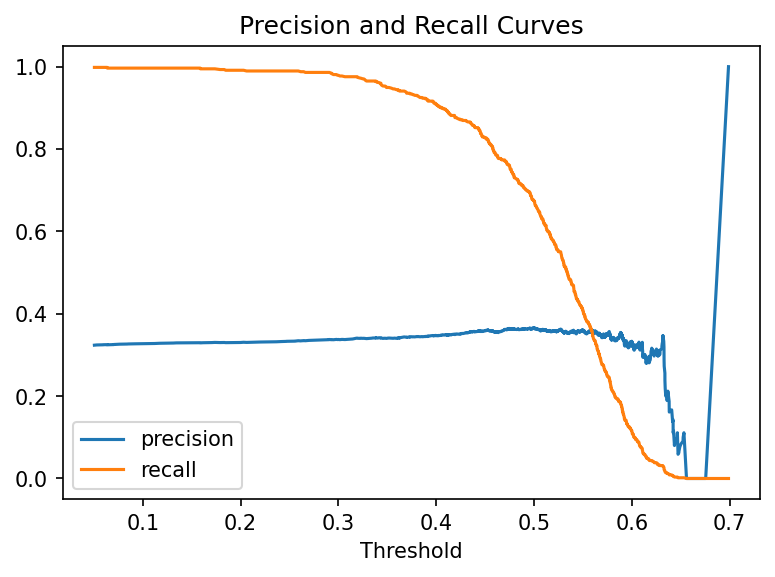

In [16]:
#Precision and Recall
print("Threshold: {}".format(thresh))
print("Precision: {:6.4f}, Recall: {:6.4f}".format(precision_score(y_test, y_pred_lr), recall_score(y_test, y_pred_lr)))

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.figure(dpi=150)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Precision and Recall Curves')

In [1]:
#confuse
def confuse(y_test, y_pred, title):
    conf = confusion_matrix(y_test, y_pred)
    summ = sum(conf[0]) + sum(conf[1])
    conf = [[conf[0][0]/summ, conf[0][1]/summ], [conf[1][0]/summ, conf[1][1]/summ]]
    plt.figure(dpi=150)
    sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, fmt='1.0%',
            xticklabels=['Dislike', 'Like'],
            yticklabels=['Dislike', 'Like'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
confuse(y_test, y_pred_lr, 'Logistic Regression Confusion Matrix')

NameError: name 'y_test' is not defined

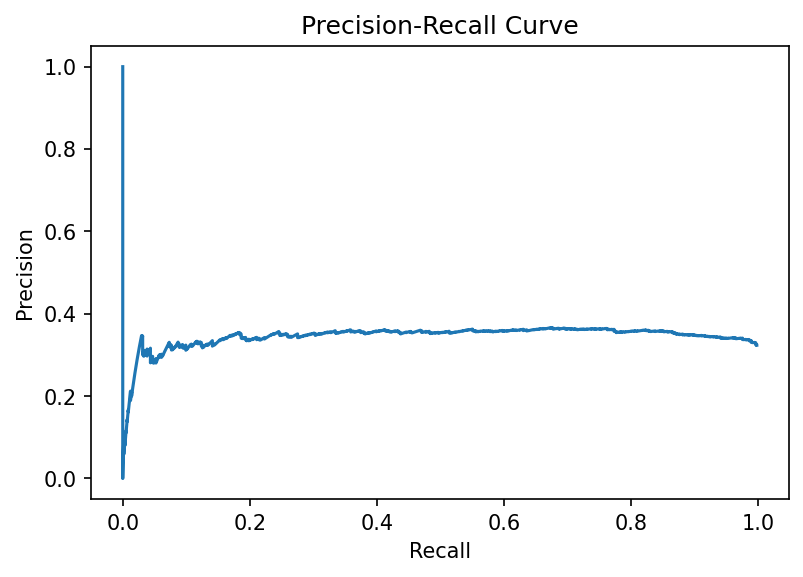

In [19]:
plt.figure(dpi=150)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

ROC AUC score =  0.5579898774980143
F1 Score =  0.474264705882353
CV Score:  0.5793402482659331


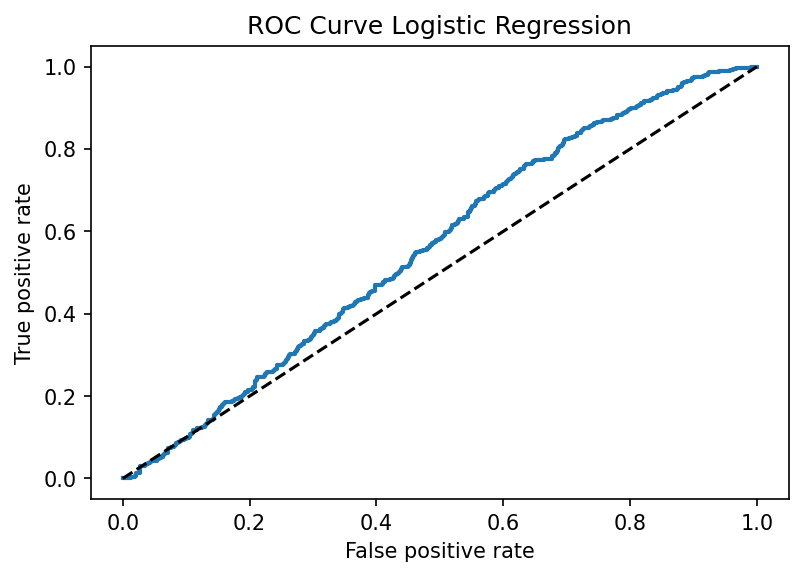

In [20]:
# roc auc
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure(dpi=150)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='black',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve Logistic Regression');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_lr))
print('F1 Score = ', f1_score(y_test, y_pred_lr))
cv_results = cross_val_score(lr, X_train_val, y_train_val, cv=5, scoring='roc_auc')
print('CV Score: ', np.mean(cv_results))

In [21]:
#random forest
rf = RandomForestClassifier(n_estimators=10000,
                            max_depth=20,
                            criterion='entropy',
                            random_state=rand_global,
                            class_weight='balanced',
                            max_features='auto')
rf.fit(X_smo_tr_val, y_smo_tr_val)
y_pred_rf = rf.predict(X_val)

In [22]:
y_pred_rf = rf.predict(X_test)
thresh_rf = 0.48

In [23]:
#Precision and Recall
print("Threshold: {}".format(thresh_rf))
print("Precision: {:6.4f}, Recall: {:6.4f}".format(precision_score(y_test, y_pred_rf), recall_score(y_test, y_pred_rf)))

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.figure(dpi=150)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold')
plt.title('Precision and Recall Curves')

In [ ]:
def confuse(y_test, y_pred, title):
    conf = confusion_matrix(y_test, y_pred)
    summ = sum(conf[0]) + sum(conf[1])
    conf = [[conf[0][0]/summ, conf[0][1]/summ], [conf[1][0]/summ, conf[1][1]/summ]]
    plt.figure(dpi=150)
    sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, fmt='1.0%',
            xticklabels=['Dislike', 'Like'],
            yticklabels=['Dislike', 'Like'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
confuse(y_test, y_pred_rf, 'Random Forest Confusion Matrix')

In [25]:
# plt.figure(dpi=150)
# plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve");

In [26]:
# #roc auc
# fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
# plt.figure(dpi=150)
# plt.plot(fpr, tpr,lw=2)
# plt.plot([0,1],[0,1],c='black',ls='--')
# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])

# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve for Default');
print("ROC AUC score = ", roc_auc_score(y_test, y_pred_rf))
print('F1 Score = ', f1_score(y_test, y_pred_rf))
# # cv_results = cross_val_score(rf, X_train_val, y_train_val, cv=5, scoring='roc_auc')
# # print('CV Score: ', np.mean(cv_results))

ROC AUC score =  0.5429090308255115
F1 Score =  0.4177310293012773


In [27]:
# #SVM
# svmod = svm.SVC(C=1.0,
#                 kernel='rbf',
#                 gamma='scale',
#                 probability=True,
#                 cache_size=2000,
#                 max_iter=5000,
#                 random_state=rand_global)
# svmod.fit(X_train_val, y_train_val)
# y_pred_svm = svmod.predict(X_test)
# thresh_svm = 0.4

In [28]:
# #Precision and Recall
# print("Threshold: {}".format(thresh_svm))
# print("Precision: {:6.4f}, Recall: {:6.4f}".format(precision_score(y_test, y_pred_svm), recall_score(y_test, y_pred_svm)))

# precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, svmod.predict_proba(X_test)[:,1])

# plt.figure(dpi=150)
# plt.plot(threshold_curve, precision_curve[1:],label='precision')
# plt.plot(threshold_curve, recall_curve[1:], label='recall')
# plt.legend(loc='lower left')
# plt.xlabel('Threshold')
# plt.title('Precision and Recall Curves')

# plt.figure(dpi=150)
# plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve");

In [29]:
# #confusion
# svm_conf = confusion_matrix(y_test, y_pred_svm)
# confperc = [[svm_conf[0][0]/sum(svm_conf[0]),svm_conf[0][1]/sum(svm_conf[0])],[svm_conf[1][0]/sum(svm_conf[1]), svm_conf[1][1]/sum(svm_conf[1])]]
# plt.figure(dpi=150)
# sns.heatmap(confperc, cmap=plt.cm.Greens, annot=True, square=True, fmt='1.0%',
#            xticklabels=['Dislike', 'Like'],
#            yticklabels=['Dislike', 'Like'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('SVM Confusion Matrix')

In [30]:
# #roc auc
# fpr, tpr, thresholds = roc_curve(y_test, svmod.predict_proba(X_test)[:,1])
# plt.figure(dpi=150)
# plt.plot(fpr, tpr,lw=2)
# plt.plot([0,1],[0,1],c='black',ls='--')
# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])

# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve for Default');
# print("ROC AUC score = ", roc_auc_score(y_test, y_pred_svm))
# print('F1 Score = ', f1_score(y_test, y_pred_svm))
# # cv_results = cross_val_score(svmod, X_train_val, y_train_val, cv=5, scoring='roc_auc')
# # print('CV Score: ', np.mean(cv_results))